This notebook was tested on an NVIDIA Tesla K80 GPU, although we anticipate that similar hardware should also work.
The ONNX inference runtime was tested on CPU and was optimized for memory consumption through quantization. If memory
is not an issue, using BERT instead of DistilBERT and skipping the quantization step should lead to performance gains.
Parts of this notebook are adapted from resources from ChrisMcCormickAI.

The training data used to train this iteration of the text quality watchdog model was collected from CommonCrawl. The full
dataset used to train the production model contains 18,000 text examples. The sample training dataset provided contains 100 text
examples, and is intended solely for demonstrative purposes.

Standard Python packages used: Pandas, Numpy, Tensorflow, Pytorch, Tokenizers, Transformers, Matplotlib, Seaborn, Scikit-learn, Onnx, Onnxruntime.<br>
Modules from the Python Standard Library: re, time, datetime, random

**Load Training Data**

In [1]:
# The training dataset contains the following fields:
#
# text => the raw text extracted from each document during document cracking
# score => the oov score assigned to each example, score range [0,1] indicates % of out-of-vocab words
# filename => filename of original document for downstream data analysis

import pandas as pd

print('Parsing the dataset .tsv file')

data = pd.read_csv('train_data_sample.tsv', sep='\t')

print('    Done.')

Parsing the dataset .tsv file
    Done.


**Connect To Hardware Accelerator**

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA Tesla K80


**Preprocess Data**

In [4]:
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("./bert-base-uncased-vocab.txt")
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", length=128)
tokenizer.enable_truncation(max_length=128)

In [5]:
import numpy as np
import re

# Tokenize text input and compute attention masks for each training example

input_ids = []
attention_masks = []

for text_example in data.text:

    # Explicitly truncate text to 128 whitespace-separated tokens
    space_idx = [space.start() for space in re.finditer(' ', text_example)]
    if len(space_idx) >= 128:
        end_idx = space_idx[127]
        text_example = (text_example[:end_idx])

    encoding = tokenizer.encode(text_example)

    input_ids.append(encoding.ids)
    attention_masks.append(encoding.attention_mask)

In [6]:
# Collect training labels

labels = data.score.values
labels = [1 if score > 0.8 else 0 for score in labels]  # binarize the labels with classification threshold of 0.8

In [7]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [8]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


**Initialize Model**

In [10]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig, DistilBertModel

# Load DistilBertForSequenceClassification, the pretrained DistilBERT model with a single 
# linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer DistilBERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [11]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [12]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

**Evaluation Utility Functions**

In [13]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [14]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


**Train Model**

In [15]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.68
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.70
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.90
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.52
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00

Training complete!


**Evaluate Model**

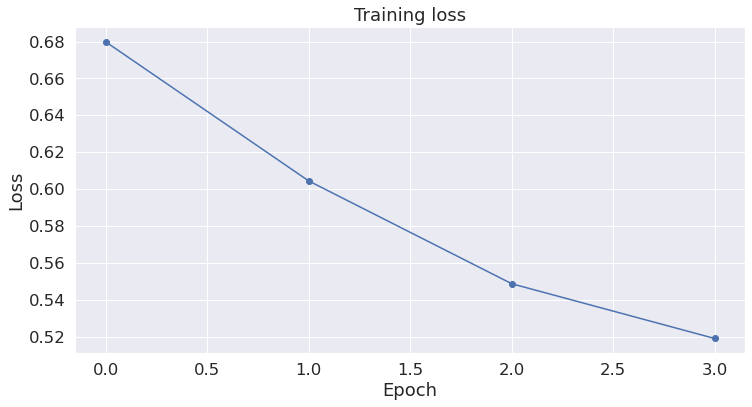

In [16]:
# If following this notebook cell-for-cell, the observed decrease in the loss function will be lower than
# that of the production model due to the small size of the sample training dataset used for demo purposes.

import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [17]:
# Prediction on validation set

print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10 test sentences...
    DONE.


In [18]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [19]:
# If following this notebook cell-for-cell, the observed predictive performance will be different than
# that of the production model due to the small size of the sample training dataset used for demo purposes.
#
# At this cell, the production Pytorch model achieves 0.932 MCC

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 1.000


In [20]:
# Save Pytorch model
torch.save(model, './watchdog_model_demo.pt')

***Convert Model to ONNX Runtime***

In [21]:
model = torch.load('./watchdog_model_demo.pt')
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [22]:
# Helper method to prepare sample inputs for ONNX

def get_ids_and_masks(text):
    tokenizer = BertWordPieceTokenizer("./bert-base-uncased-vocab.txt")
    tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", length=128)
    tokenizer.enable_truncation(max_length=128)

    input_ids = []
    attention_masks = []

    encoding = tokenizer.encode(text)
    input_ids.append(encoding.ids)
    attention_masks.append(encoding.attention_mask)

    return input_ids, attention_masks

In [23]:
# Create sample inputs and attention mask

sample_text = data.text[0]

sample_input_ids, sample_attention_masks = get_ids_and_masks(sample_text)

sample_input_ids = torch.tensor(sample_input_ids)
sample_attention_masks = torch.tensor(sample_attention_masks)

sample_input_ids = sample_input_ids.to(device)
sample_attention_masks = sample_attention_masks.to(device)

In [24]:
from torch.onnx import export

model_onnx_path = "watchdog_model_demo.onnx"

dummy_input = (
    sample_input_ids,
    sample_attention_masks
)
input_names = ["input_ids", "attention_mask"]
output_names = ["logits"]

export(
    model, dummy_input, model_onnx_path, input_names = input_names, 
    output_names = output_names
)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/transformers/modeling_utils.py:1790: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape[chunk_dim] == tensor_shape for input_tensor in input_tensors


**Quantize ONNX Model for Efficient Runtime**

In [25]:
import onnx
from onnxruntime.quantization import QuantizationMode, quantize

# Load the ONNX model
onnx_model = onnx.load("watchdog_model_demo.onnx")

quantized_model = quantize(
    model=onnx_model,
    quantization_mode=QuantizationMode.IntegerOps,
    force_fusions=True,
    symmetric_weight=True
)

quantized_model_path = "watchdog_model_quantized_demo.onnx"

# Save model
onnx.save_model(quantized_model, quantized_model_path)

         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.


**Quantized Performance Check**

In [26]:
import onnx

# Load the ONNX model
model = onnx.load("watchdog_model_quantized_demo.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %input_ids[INT64, 1x128]\n  %attention_mask[INT64, 1x128]\n) initializers (\n  %distilbert.embeddings.LayerNorm.weight[FLOAT, 768]\n  %distilbert.embeddings.LayerNorm.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.attention.q_lin.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.attention.k_lin.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.attention.v_lin.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.attention.out_lin.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.sa_layer_norm.weight[FLOAT, 768]\n  %distilbert.transformer.layer.0.sa_layer_norm.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.ffn.lin1.bias[FLOAT, 3072]\n  %distilbert.transformer.layer.0.ffn.lin2.bias[FLOAT, 768]\n  %distilbert.transformer.layer.0.output_layer_norm.weight[FLOAT, 768]\n  %distilbert.transformer.layer.0.output_layer_norm.bias[FLOAT, 768]\n  %distilbert.transformer.layer.1.attention.q_lin.bias[FLOAT, 768]\n  %distilbert.transformer.layer.1.attention.k

In [27]:
import onnxruntime as ort

# Load the Quantized ONNX Runtime
ort_session = ort.InferenceSession("watchdog_model_quantized_demo.onnx")

In [28]:
# Re-load validation data, cannot be in tensor form
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [29]:
# Tracking variables 
predictions , true_labels = [], []

for i in range(len(validation_inputs)):

    cur_input_ids = [validation_inputs[i]]
    cur_mask = [validation_masks[i]]

    input_dict = {"input_ids" : cur_input_ids, "attention_mask" : cur_mask}

    outputs = ort_session.run(["logits"], input_dict)
    logits = outputs[0]
    flat_prediction = np.argmax(logits, axis=1)[0]

    # Store predictions and true labels
    predictions.append(flat_prediction)
    true_labels.append(validation_labels[i])

In [30]:
# Calculate final accuracy and MCC score
#
# If following this notebook cell-for-cell, the observed predictive performance will be lower than
# that of the production model due to the small size of the sample training dataset used for demo purposes.
#
# At this cell, the production ONNX model achieves 0.933 MCC and 0.967 accuracy

from sklearn.metrics import matthews_corrcoef
print('MCC: %.6f' % matthews_corrcoef(true_labels, predictions))

from sklearn.metrics import accuracy_score
print('Accuracy: %.6f' % accuracy_score(true_labels, predictions))

MCC: 1.000000
Accuracy: 1.000000
